In [35]:
import import_ipynb
import pandas as pd
import ModelCreation
import numpy as np

pipe = ModelCreation.rf
rf = pipe["regressor"]
df = pd.read_excel("AUtoNL_20220928.xlsx")

# All nodes on the route
locs = df[["locationType", "cityName", "countryName"]].to_numpy().astype('str')
nodes = np.unique(locs, axis=0)
node_cols = [f'{node[0]}_{node[1]}_{node[2]}_visited' for node in nodes] + [f'{node[0]}_{node[1]}_{node[2]}_planned' for node in nodes]
node_df = pd.DataFrame(np.zeros((df.shape[0], len(node_cols)), dtype=np.bool8), columns=node_cols)
df.reset_index(inplace=True, drop=True)
df = pd.concat([df, node_df], axis=1)
df = df[df["ordSeaFreightMainTransportInvolvement"] == "J"]
df["ordJFHArrangeLoadingPickup"].fillna("", inplace=True)
df["ordJFHArrangeDelivery"].fillna("", inplace=True)
df["ordReqDeliveryDate"].fillna("", inplace=True)

df = ModelCreation.preprocess_common(df)
df_copy = df.copy()

In [36]:
df = df_copy.copy()

def is_visited(row):
    return not (pd.isnull(row['actualArrDate']) and pd.isnull(row['actualDepDate']))

def is_planned(row):
    return not is_visited(row)


df_finished = df[df['ATA'].notna()]
df = df[df['ATA'].isna()]
df.drop(columns=['ATA'], inplace=True)

df["departureOrigin"] = pd.to_datetime(df["departureOrigin"])
df["departureMonthOrigin"] = df["departureOrigin"].apply(lambda x : x.month)
df["departureDayOrigin"] = df["departureOrigin"].apply(lambda x : x.isoweekday())

# set visited path and future path
ss = np.unique(df["shipmentID"])
paths = [df[df["shipmentID"] == s][["locationType", "cityName", "countryName"]].apply(lambda x : ModelCreation.node_name(x), axis=1) for s in ss]

for path, shipment in zip(paths, ss):
    path_visited = df[df["shipmentID"] == shipment][["actualArrDate", "actualDepDate"]].apply(lambda x : is_visited(x), axis=1)
    path_planned = df[df["shipmentID"] == shipment][["actualArrDate", "actualDepDate"]].apply(lambda x : is_planned(x), axis=1)
    # first node is always visited
    df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == 1), [f"{n}_visited" for n in path[:1]]] = True
    if len(path) > 1:
        for i in range(1, len(path)):
            if path_visited.iloc[i]:
                df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i+1), [f"{n}_visited" for n in path[:i]]] = True
            if path_planned.iloc[i]:
                df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i+1), [f"{n}_planned" for n in path[i-1:]]] = True

    # set ETA for all shipment records and convert to time delta
    try:
        # TODO: should this not be the orderReqDate? Now shipments that have no dep date do not have an ETA ever.
        shipment_dep_row = df.loc[(df["shipmentID"] == shipment) & (df["actualDepDate"].notnull())].iloc[0]
    except Exception as e:
        df.loc[df["shipmentID"] == shipment, ["ETA",]] = pd.Timedelta(0)
        continue
    shipment_est_arr = shipment_dep_row['ETA']
    shipment_dep = shipment_dep_row['actualDepDate']
    if not pd.isnull(shipment_est_arr):
        df.loc[df["shipmentID"] == shipment, ["ETA",]] = shipment_est_arr - shipment_dep
    else:
        df.loc[df["shipmentID"] == shipment, ["ETA",]] = pd.Timedelta(0)
        
df["ETA"] = (df["ETA"] / pd.Timedelta(hours=1))

for node in nodes:
    df[f'{node[0]}_{node[1]}_{node[2]}_visited'] = df[f'{node[0]}_{node[1]}_{node[2]}_visited'].astype(int)
    df[f'{node[0]}_{node[1]}_{node[2]}_planned'] = df[f'{node[0]}_{node[1]}_{node[2]}_planned'].astype(int)

shipments = df["shipmentID"]
df_all_cols = df.copy()
df = df.drop(columns=["progress", "departureOrigin", "estimatedDepDate", "created", "readyDate", "estimatedArrDate", "actualDepDate", "prtReqPOL", "prtReqPOD", "ordReqShipDate", "ordaCreateDate", "ordReqDeliveryDate", "latitude" , "longitude", "actualArrDate", "ordExpectedNBOfContainers", "ordGrossWeightKGM", "rowNo", "shipmentID", "originDestination", "locationType", "cityName", "countryName", "ordtType", "ordJFHArrangeLoadingPickup", "ordSeaFreightMainTransportInvolvement", "ordJFHArrangeDelivery"])


In [3]:
df['P1_Le Havre_France_planned'] = 0 # not present in the ongoing shipments
df = df[['A _Balhannah_Australia_visited', 'A _Relbia_Australia_visited',
       'P2_Antwerpen_Belgium_visited', 'A _Tiel_Netherlands_planned',
       'P2_Antwerpen_Belgium_planned', 'ETA', 'departureMonthOrigin',
       'A _McLaren Vale_Australia_visited', 'P1_Le Havre_France_planned',
       'pastTimeToOrigin', 'P1_Valencia_Spain_planned', 'totalWeight',
       'A _Tilburg_Netherlands_planned', 'H1_Outer Harbor_Australia_visited',
       'A _Melbourne_Australia_visited', 'origin', 'destination',
       'consolidation', 'serviceType', 'portOfLoading', 'portOfDischarge',
       'portOfLoadingLate']]
predictions = pipe.predict(df)

In [4]:
# the last prediction is what the prediction would be with all current information available
results_dict = {shipment : [prediction for shipment_id, prediction in zip(shipments, predictions) if shipment_id == shipment] for shipment in shipments}
with open('output/actual_predictions.csv', 'w+') as f:   
    for shipment, predictions in results_dict.items():
        f.write(f'{shipment},{predictions[-1]}\n')

In [54]:
# more verbose output file
df_refs = pd.read_excel("AUtoNL_WithOrderReference.xlsx")
df_refs = df_refs[["shipmentID", "OrderReference"]]
with open('output/actual_predictions_verbose.csv', 'w+') as f:
    f.write("shipment, prediction_hrs, order_ref, dep_date, prediction_date\n")
    for shipment, predictions in results_dict.items():
        prediction = predictions[-1]
        order_refs = df_refs.loc[df_refs["shipmentID"] == shipment]["OrderReference"]
        order_ref = None
        predicted_ata_absolute = None
        if order_refs.size:
            order_ref = order_refs.iloc[0]
        shipment_dep_rows = df_all_cols.loc[(df_all_cols["shipmentID"] == shipment) & (df_all_cols["actualDepDate"].notnull())]
        if shipment_dep_rows.size:
            shipment_dep = shipment_dep_rows['actualDepDate'].iloc[0]
            predicted_ata_absolute = (shipment_dep + pd.DateOffset(hours=prediction)).date()
            f.write(f'{shipment},{prediction},{order_ref},{shipment_dep.date()},{predicted_ata_absolute}\n')

In [6]:
df[df_all_cols["shipmentID"] == 4673847].to_csv('output/shipment_4673847_20220907.csv')

[[], [], [], [], [], [], [], [-170.80198076923057, -167.95899999999972, -204.66866666666667, -162.80198076923057, -243.48510389610388, -228.765, -220.765, -222.495, -221.495], [2.7238525641027778, -90.23, -91.23, -151.37852056277055, -93.23, -94.23, -95.5, -203.625, -436.69, -169.53456926406972], [], [133.30633333333333]]


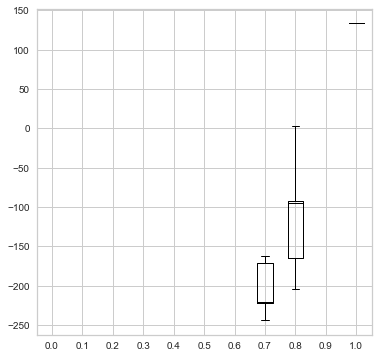

In [200]:
df_predicted_now_finished = pd.read_csv("output/actual_predictions_verbose.csv")

residuals = []
progress = []
predictions = []
with open('output/actual_predictions_complete.csv', 'w+') as f:
    for shipment, prediction_hrs, order_ref, dep_date, prediction_date in df_predicted_now_finished.values:
        row = df_finished.loc[df_finished["shipmentID"] == shipment]
        if row.size:
            actual_ata = row.iloc[-1]["ATA"]
            if actual_ata < pd.to_datetime('2022-09-07'):
                continue
            predicted_ata = pd.to_datetime(dep_date) + pd.Timedelta(hours=prediction_hrs)
            error = (actual_ata - predicted_ata) / pd.Timedelta(hours=1)
            predicted_at_hours_from_dep_date = (pd.to_datetime(dep_date) - pd.to_datetime('2022-09-07')) / pd.Timedelta(hours=1)
            ata_at_hours_from_dep_date = (pd.to_datetime(dep_date) - actual_ata) / pd.Timedelta(hours=1)
            progress_at_prediction = predicted_at_hours_from_dep_date / ata_at_hours_from_dep_date
            residuals.append(error)
            progress.append(progress_at_prediction)
            predictions.append(predicted_ata)
            f.write(f"{shipment}, {actual_ata}, {predicted_ata}, {progress_at_prediction}, {error}\n")

import matplotlib.pyplot as plt
num_bins = 11
bins = np.linspace(0.0, 1.0, num_bins)
relative_bins = np.digitize(progress, bins)
combined_vals = np.column_stack((progress, predictions, residuals, relative_bins))
fig, axes = plt.subplots(figsize=(6,6))

binned_series = [[] for _ in range(num_bins)]
for v in combined_vals:
    binned_series[v[3]].append(v[2])
print(binned_series)

_ = axes.boxplot(binned_series, showfliers=False, medianprops={'color' : 'black'}, labels=[round(b, 2) for b in bins])
fig.savefig('output/progressboxplots_actual_shipments.png')